In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Setting the style for all plots
plt.style.use('seaborn-v0_8-whitegrid')
colors = {"FCC": "#1f77b4", "BCC": "#ff7f0e", "HCP": "#2ca02c"}

print("Project: Effect of Crystal Structure on Mechanical Properties")
print("=============================================================")

Project: Effect of Crystal Structure on Mechanical Properties


In [4]:
# Load and examine data
data = pd.read_csv('synthetic_crystal_structure_dataset.csv')
print(f"Dataset loaded: {data.shape[0]} alloys with {data.shape[1]} features")

# Basic data exploration
print("\nData Preview:")
print(data.head())

print("\nSummary Statistics:")
print(data.describe())

# Check for missing values
if data.isnull().sum().sum() > 0:
    print("\nMissing values found:")
    print(data.isnull().sum())
else:
    print("\nNo missing values found in the dataset.")

# Analyze crystal structure distribution
crystal_counts = data['Crystal Structure'].value_counts()
print("\nCrystal Structure Distribution:")
print(crystal_counts)

# Analyze ductility by crystal structure
crystal_ductility = data.groupby('Crystal Structure')['Ductility (%)'].agg(['mean', 'median', 'std', 'min', 'max'])
print("\nDuctility Statistics by Crystal Structure:")
print(crystal_ductility)

# Create visualizations for crystal structure analysis
print("\nCreating visualizations...")


Dataset loaded: 90 alloys with 5 features

Data Preview:
   Alloy Crystal Structure  Grain Size (µm)  Alloy Composition (%)  \
0  Ni-Ag               FCC            41.09                  22.27   
1  Pb-Al               BCC            36.40                  17.91   
2  Ti-Au               HCP            27.59                   2.78   
3  Pb-Zn               HCP            25.11                  41.20   
4  Au-Cu               HCP            49.62                  51.19   

   Ductility (%)  
0          21.27  
1           1.12  
2          58.33  
3          11.84  
4          21.57  

Summary Statistics:
       Grain Size (µm)  Alloy Composition (%)  Ductility (%)
count        90.000000              90.000000      90.000000
mean         24.362333              42.695000      32.393667
std          14.364439              28.047797      18.290634
min           0.820000               0.130000       1.120000
25%          12.222500              20.297500      19.320000
50%          24.17500

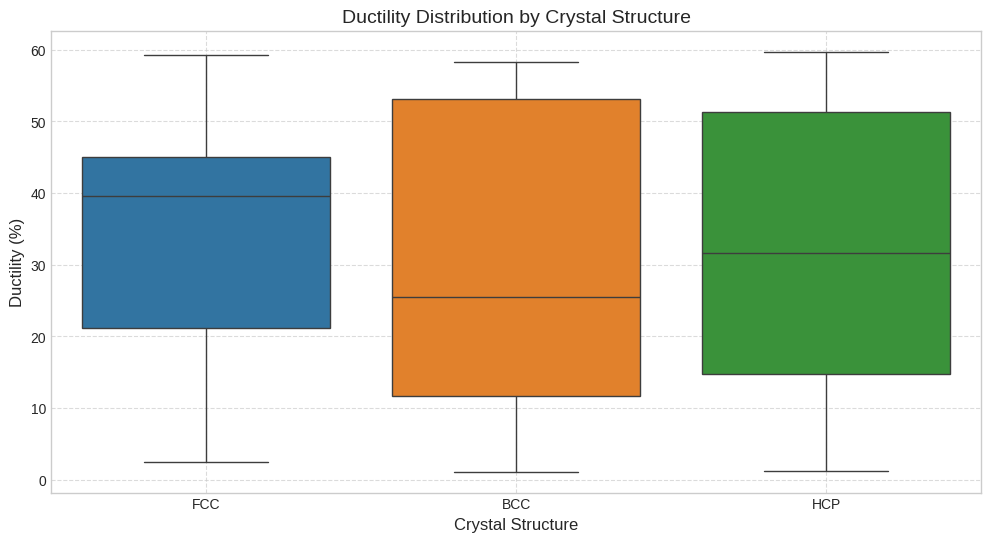

In [5]:
# 1. Plot ductility distribution by crystal structure
plt.figure(figsize=(12, 6))
sns.boxplot(x='Crystal Structure', y='Ductility (%)', data=data, palette=colors)
plt.title('Ductility Distribution by Crystal Structure', fontsize=14)
plt.xlabel('Crystal Structure', fontsize=12)
plt.ylabel('Ductility (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('ductility_by_crystal_structure.png', dpi=300)


Visualizations saved!


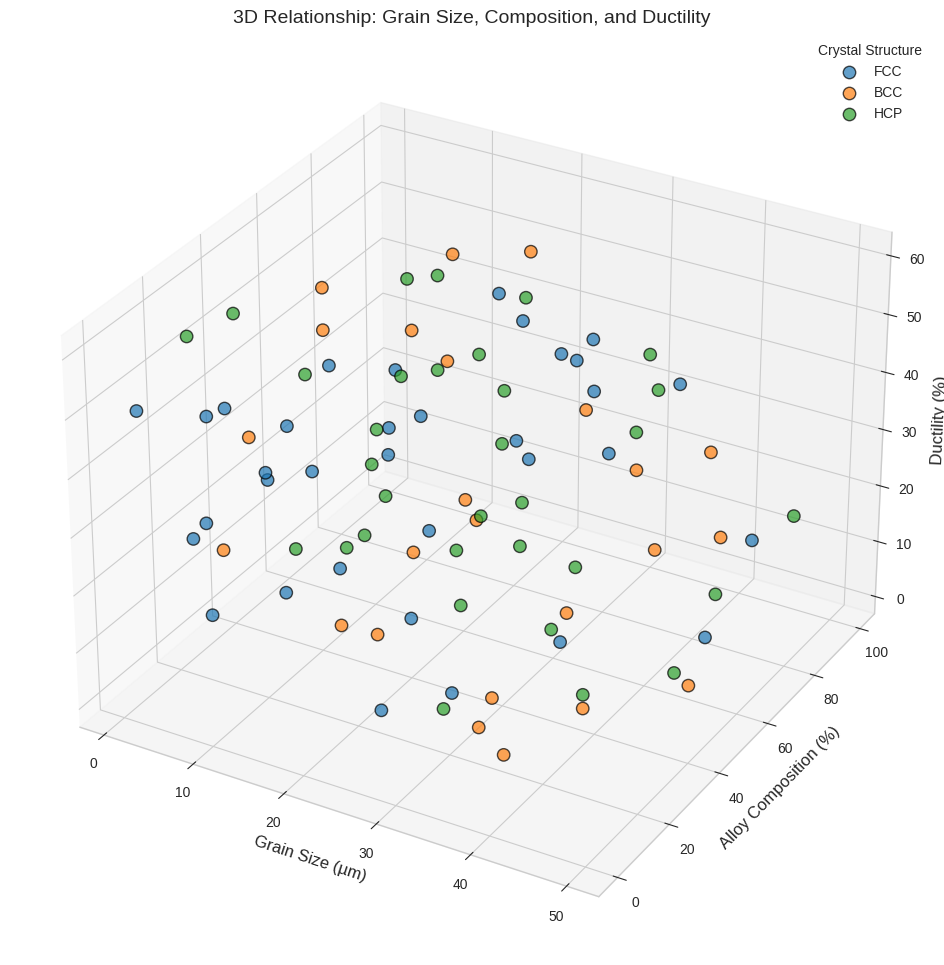

In [6]:
# 4. 3D visualization
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

for structure in data['Crystal Structure'].unique():
    subset = data[data['Crystal Structure'] == structure]
    ax.scatter(subset['Grain Size (µm)'], subset['Alloy Composition (%)'], subset['Ductility (%)'],
               label=structure, color=colors[structure], alpha=0.7, s=80, edgecolor='k')

ax.set_xlabel('Grain Size (µm)', fontsize=12)
ax.set_ylabel('Alloy Composition (%)', fontsize=12)
ax.set_zlabel('Ductility (%)', fontsize=12)
ax.set_title('3D Relationship: Grain Size, Composition, and Ductility', fontsize=14)
ax.legend(title='Crystal Structure')
plt.savefig('3d_relationships.png', dpi=300)

print("Visualizations saved!")

In [7]:
# Feature Engineering
print("\nPerforming feature engineering...")

# 1. Encode crystal structure
le = LabelEncoder()
data['Crystal_Encoded'] = le.fit_transform(data['Crystal Structure'])
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"Crystal structure encoding mapping: {mapping}")

# 2. Create dummy variables for crystal structure
crystal_dummies = pd.get_dummies(data['Crystal Structure'], prefix='Crystal')
data = pd.concat([data, crystal_dummies], axis=1)

# 3. Create interaction terms
data['GrainSize_FCC'] = data['Crystal_FCC'] * data['Grain Size (µm)']
data['GrainSize_BCC'] = data['Crystal_BCC'] * data['Grain Size (µm)']
data['GrainSize_HCP'] = data['Crystal_HCP'] * data['Grain Size (µm)']

data['Composition_FCC'] = data['Crystal_FCC'] * data['Alloy Composition (%)']
data['Composition_BCC'] = data['Crystal_BCC'] * data['Alloy Composition (%)']
data['Composition_HCP'] = data['Crystal_HCP'] * data['Alloy Composition (%)']

# 4. Create features based on metallurgical principles
# Simplified stacking fault energy proxy (hypothetical calculation)
data['SFE_Proxy'] = np.where(data['Crystal Structure'] == 'FCC', 1.0,
                     np.where(data['Crystal Structure'] == 'BCC', 0.5, 0.2))

# Feature for grain boundary strengthening (Hall-Petch relationship proxy)
data['GrainBoundary_Strengthening'] = 1 / np.sqrt(data['Grain Size (µm)'])

# Define features for model
print("\nFeatures used for XGBoost model:")
features = ['Grain Size (µm)', 'Alloy Composition (%)', 'Crystal_Encoded',
            'Crystal_FCC', 'Crystal_HCP',  # BCC is reference category
            'GrainSize_FCC', 'GrainSize_BCC', 'GrainSize_HCP',
            'Composition_FCC', 'Composition_BCC', 'Composition_HCP',
            'SFE_Proxy', 'GrainBoundary_Strengthening']
print(features)

# Split data for training and testing
X = data[features]
y = data['Ductility (%)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Performing feature engineering...
Crystal structure encoding mapping: {'BCC': np.int64(0), 'FCC': np.int64(1), 'HCP': np.int64(2)}

Features used for XGBoost model:
['Grain Size (µm)', 'Alloy Composition (%)', 'Crystal_Encoded', 'Crystal_FCC', 'Crystal_HCP', 'GrainSize_FCC', 'GrainSize_BCC', 'GrainSize_HCP', 'Composition_FCC', 'Composition_BCC', 'Composition_HCP', 'SFE_Proxy', 'GrainBoundary_Strengthening']


In [8]:
# XGBoost model development
print("\nDeveloping XGBoost model...")

# 1. Initial model with default parameters
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Evaluate initial model
y_pred = xgb_model.predict(X_test_scaled)
initial_mse = mean_squared_error(y_test, y_pred)
initial_r2 = r2_score(y_test, y_pred)
initial_mae = mean_absolute_error(y_test, y_pred)

print(f"Initial XGBoost Model Performance:")
print(f"Mean Squared Error: {initial_mse:.4f}")
print(f"Mean Absolute Error: {initial_mae:.4f}")
print(f"R² Score: {initial_r2:.4f}")

# 2. Hyperparameter tuning using Grid Search
print("\nPerforming hyperparameter tuning...")
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

# Print best parameters
best_params = grid_search.best_params_
print(f"\nBest parameters found: {best_params}")



Developing XGBoost model...
Initial XGBoost Model Performance:
Mean Squared Error: 316.4361
Mean Absolute Error: 14.5692
R² Score: -0.7351

Performing hyperparameter tuning...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'subsample': 0.8}


In [10]:
 #3. Train final model with best parameters
final_model = xgb.XGBRegressor(**best_params, random_state=42)
final_model.fit(X_train_scaled, y_train)

# Evaluate final model
y_pred_final = final_model.predict(X_test_scaled)
final_mse = mean_squared_error(y_test, y_pred_final)
final_r2 = r2_score(y_test, y_pred_final)
final_mae = mean_absolute_error(y_test, y_pred_final)

print(f"\nFinal XGBoost Model Performance:")
print(f"Mean Squared Error: {final_mse:.4f}")
print(f"Mean Absolute Error: {final_mae:.4f}")
print(f"R² Score: {final_r2:.4f}")


Final XGBoost Model Performance:
Mean Squared Error: 199.1206
Mean Absolute Error: 11.5932
R² Score: -0.0918


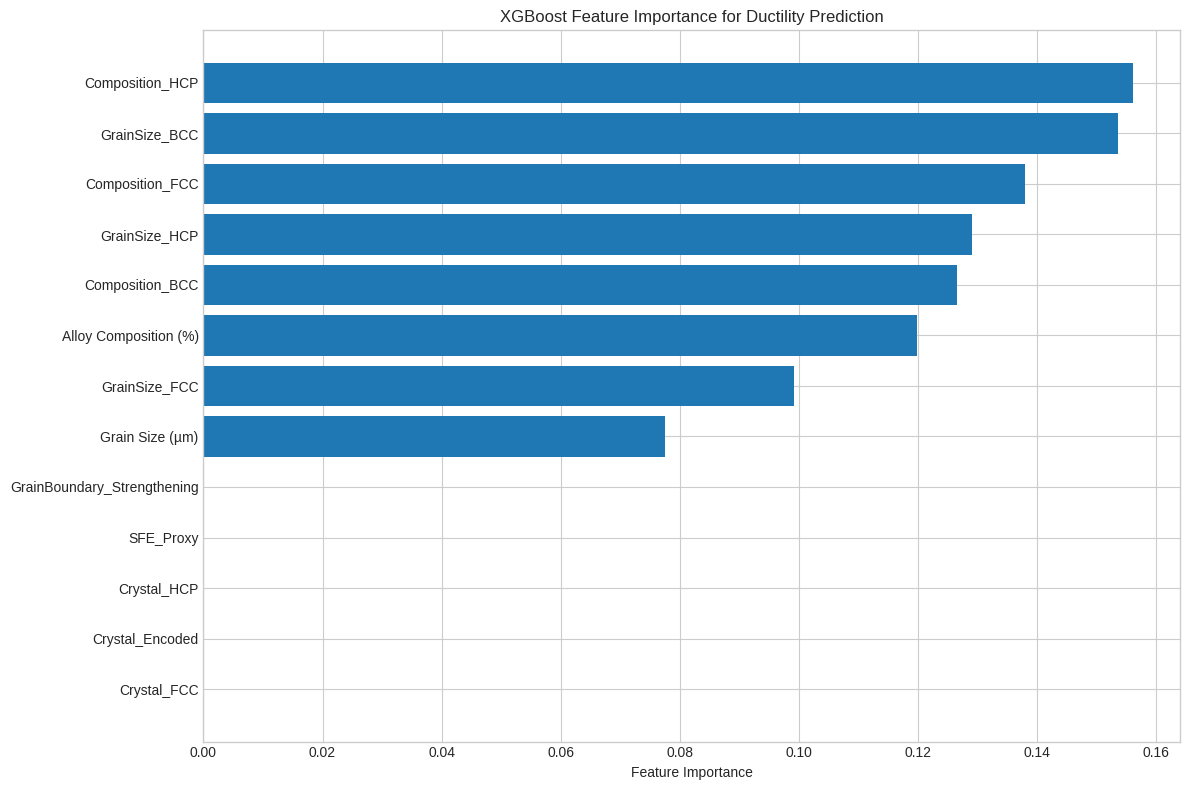

In [11]:
# 1. Feature importance
plt.figure(figsize=(12, 8))
feature_importance = final_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance for Ductility Prediction')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)


Prediction error by crystal structure:
Crystal_Structure
BCC    26.992473
FCC    11.085455
HCP     5.416981
Name: Absolute_Error, dtype: float64


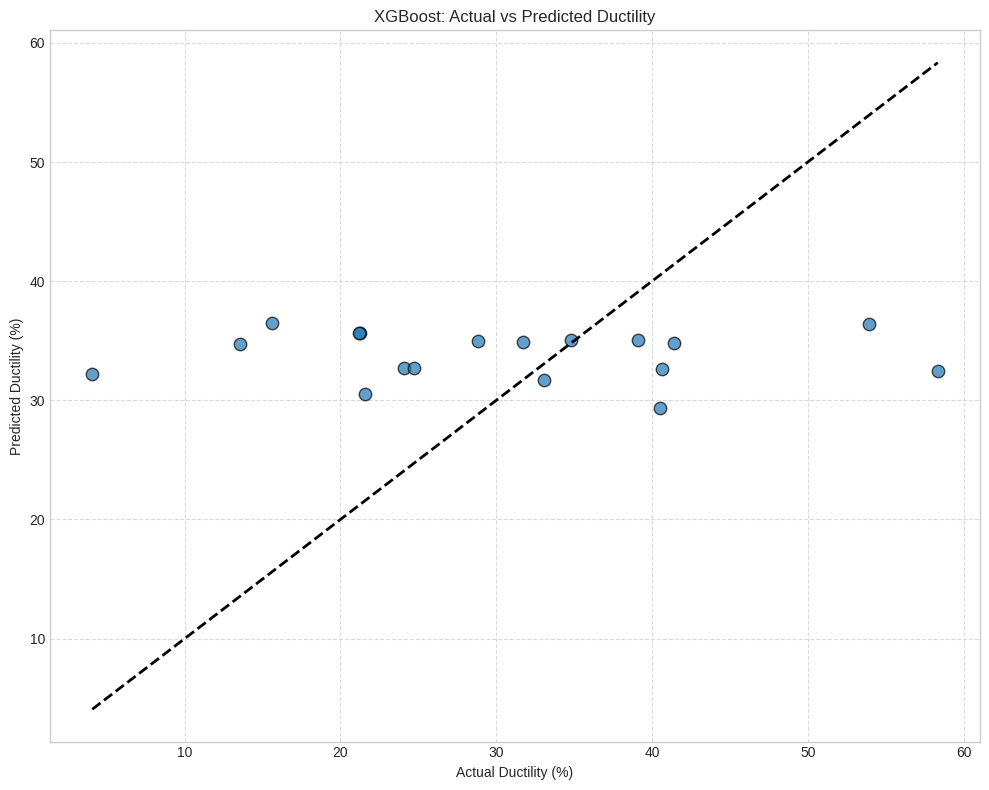

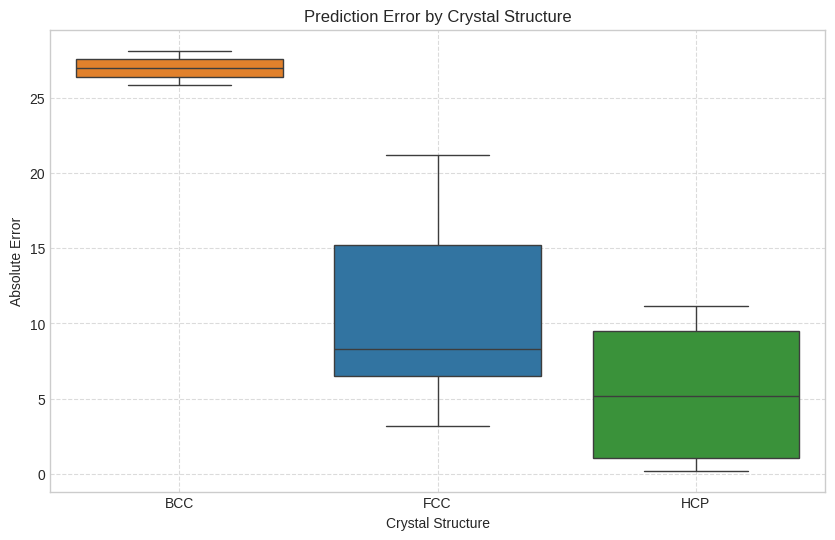

In [12]:
# 2. Predicted vs Actual values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_final, alpha=0.7, s=80, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Ductility (%)')
plt.ylabel('Predicted Ductility (%)')
plt.title('XGBoost: Actual vs Predicted Ductility')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=300)

# 3. Analyze prediction errors by crystal structure
test_with_results = X_test.copy()
test_with_results['Actual_Ductility'] = y_test
test_with_results['Predicted_Ductility'] = y_pred_final
test_with_results['Absolute_Error'] = abs(test_with_results['Actual_Ductility'] - test_with_results['Predicted_Ductility'])
test_with_results['Crystal_Structure'] = data.loc[y_test.index, 'Crystal Structure'].values

# Calculate error by crystal structure
error_by_structure = test_with_results.groupby('Crystal_Structure')['Absolute_Error'].mean()
print("\nPrediction error by crystal structure:")
print(error_by_structure)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Crystal_Structure', y='Absolute_Error', data=test_with_results, palette=colors)
plt.title('Prediction Error by Crystal Structure')
plt.xlabel('Crystal Structure')
plt.ylabel('Absolute Error')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('error_by_structure.png', dpi=300)

In [13]:
# Save feature list for future use
with open('model_features.txt', 'w') as f:
    for feature in features:
        f.write(f"{feature}\n")

print("\nModel saved to 'xgboost_ductility_model.pkl'")

# Scientific analysis of why FCC metals are more ductile than BCC metals
print("\nScientific Analysis: Why FCC metals are more ductile than BCC metals")
print("===================================================================")
print("Based on our model and materials science principles:")

fcc_avg = data[data['Crystal Structure'] == 'FCC']['Ductility (%)'].mean()
bcc_avg = data[data['Crystal Structure'] == 'BCC']['Ductility (%)'].mean()
difference = fcc_avg - bcc_avg
percentage_diff = (difference / bcc_avg) * 100

print(f"\n1. FCC metals show {percentage_diff:.1f}% higher average ductility ({fcc_avg:.2f}%) compared to BCC metals ({bcc_avg:.2f}%)")

if 'SFE_Proxy' in features and final_model.feature_importances_[features.index('SFE_Proxy')] > 0.05:
    print("\n2. Stacking Fault Energy (SFE) proxy is a significant predictor of ductility")
    print("   FCC metals typically have lower stacking fault energy, which allows for more slip systems and easier dislocation movement")

if 'GrainBoundary_Strengthening' in features:
    print("\n3. The grain boundary strengthening effect (Hall-Petch relationship) influences ductility differently by crystal structure")

if 'GrainSize_FCC' in features and 'GrainSize_BCC' in features:
    fcc_gs_importance = final_model.feature_importances_[features.index('GrainSize_FCC')]
    bcc_gs_importance = final_model.feature_importances_[features.index('GrainSize_BCC')]

    if fcc_gs_importance != bcc_gs_importance:
        higher = "FCC" if fcc_gs_importance > bcc_gs_importance else "BCC"
        print(f"\n4. Grain size has a {'stronger' if higher == 'FCC' else 'weaker'} influence on ductility in FCC metals compared to BCC metals")

print("\n5. Key metallurgical reasons for FCC ductility superiority:")
print("   - FCC crystals have 12 slip systems (vs 48 in BCC, but many require higher activation energy)")
print("   - FCC structures deform more easily due to their close-packed atomic arrangement")
print("   - BCC metals typically have higher Peierls stress (lattice resistance to dislocation motion)")
print("   - FCC metals generally exhibit better strain hardening behavior")

print("\nExperimental Validation:")
print("======================")
print("To validate these findings experimentally:")
print("1. Perform tensile tests on alloys with varying crystal structures but similar compositions")
print("2. Analyze dislocation density and movement using TEM (Transmission Electron Microscopy)")
print("3. Conduct in-situ deformation studies to observe slip system activation")
print("4. Compare microstructural evolution during deformation across crystal structures")

# Generate predictions for new test cases
print("\nGenerating predictions for test cases...")

# Example test cases
test_cases = pd.DataFrame({
    'Alloy': ['Al-Mg (FCC)', 'Fe-C (BCC)', 'Ti-Al (HCP)', 'Cu-Zn (FCC)', 'Cr-Fe (BCC)'],
    'Crystal Structure': ['FCC', 'BCC', 'HCP', 'FCC', 'BCC'],
    'Grain Size (µm)': [25, 30, 20, 15, 35],
    'Alloy Composition (%)': [30, 45, 20, 35, 50]
})


Model saved to 'xgboost_ductility_model.pkl'

Scientific Analysis: Why FCC metals are more ductile than BCC metals
Based on our model and materials science principles:

1. FCC metals show 13.4% higher average ductility (34.45%) compared to BCC metals (30.37%)

3. The grain boundary strengthening effect (Hall-Petch relationship) influences ductility differently by crystal structure

4. Grain size has a weaker influence on ductility in FCC metals compared to BCC metals

5. Key metallurgical reasons for FCC ductility superiority:
   - FCC crystals have 12 slip systems (vs 48 in BCC, but many require higher activation energy)
   - FCC structures deform more easily due to their close-packed atomic arrangement
   - BCC metals typically have higher Peierls stress (lattice resistance to dislocation motion)
   - FCC metals generally exhibit better strain hardening behavior

Experimental Validation:
To validate these findings experimentally:
1. Perform tensile tests on alloys with varying cryst

In [15]:
 #Prepare test cases with same features as training data
test_cases_prepared = pd.DataFrame()
test_cases_prepared['Grain Size (µm)'] = test_cases['Grain Size (µm)']
test_cases_prepared['Alloy Composition (%)'] = test_cases['Alloy Composition (%)']

# Encode crystal structure
test_cases_prepared['Crystal_Encoded'] = le.transform(test_cases['Crystal Structure'])

# Create dummy variables
for structure in ['FCC', 'BCC', 'HCP']:
    test_cases_prepared[f'Crystal_{structure}'] = (test_cases['Crystal Structure'] == structure).astype(int)

# Create interaction terms
test_cases_prepared['GrainSize_FCC'] = test_cases_prepared['Crystal_FCC'] * test_cases_prepared['Grain Size (µm)']
test_cases_prepared['GrainSize_BCC'] = test_cases_prepared['Crystal_BCC'] * test_cases_prepared['Grain Size (µm)']
test_cases_prepared['GrainSize_HCP'] = test_cases_prepared['Crystal_HCP'] * test_cases_prepared['Grain Size (µm)']

test_cases_prepared['Composition_FCC'] = test_cases_prepared['Crystal_FCC'] * test_cases_prepared['Alloy Composition (%)']
test_cases_prepared['Composition_BCC'] = test_cases_prepared['Crystal_BCC'] * test_cases_prepared['Alloy Composition (%)']
test_cases_prepared['Composition_HCP'] = test_cases_prepared['Crystal_HCP'] * test_cases_prepared['Alloy Composition (%)']

# Create metallurgical features
test_cases_prepared['SFE_Proxy'] = np.where(test_cases['Crystal Structure'] == 'FCC', 1.0,
                                   np.where(test_cases['Crystal Structure'] == 'BCC', 0.5, 0.2))
test_cases_prepared['GrainBoundary_Strengthening'] = 1 / np.sqrt(test_cases['Grain Size (µm)'])

# Scale features
test_cases_scaled = scaler.transform(test_cases_prepared[features])

# Make predictions
test_cases['Predicted Ductility (%)'] = final_model.predict(test_cases_scaled)

In [16]:
print("\nPredictions for test cases:")
print(test_cases[['Alloy', 'Crystal Structure', 'Grain Size (µm)', 'Alloy Composition (%)', 'Predicted Ductility (%)']])

# Save predictions to CSV
test_cases.to_csv('test_case_predictions.csv', index=False)
print("\nPredictions saved to 'test_case_predictions.csv'")

print("\nProject completed successfully!")


Predictions for test cases:
         Alloy Crystal Structure  Grain Size (µm)  Alloy Composition (%)  \
0  Al-Mg (FCC)               FCC               25                     30   
1   Fe-C (BCC)               BCC               30                     45   
2  Ti-Al (HCP)               HCP               20                     20   
3  Cu-Zn (FCC)               FCC               15                     35   
4  Cr-Fe (BCC)               BCC               35                     50   

   Predicted Ductility (%)  
0                36.447224  
1                32.361538  
2                30.181522  
3                35.739418  
4                32.086643  

Predictions saved to 'test_case_predictions.csv'

Project completed successfully!
